# Google Colab Notebook to train [Imagenette](https://github.com/fastai/imagenette)

Imagenette is a subset of 10 classes from Imagenet that are packaged up and easy to download. This notebook takes the wieghts of a ResNet34 architecture pretrained on the full Imagenet dataset as its starting point and continues training on just the 10 Imagenette categories.

This can be used as our example network for adversarial attacks and/or training for various defenses.

-Arnaldo

## GoogLeNet version

In [1]:
%matplotlib inline

In [2]:
!pip install -q torch==1.7.0 torchvision

In [3]:
from google.colab import drive
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import time
import copy
import imageio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, models, transforms
from PIL import Image

In [4]:
sns.set_theme()
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

# Download dataset

You only need to run the cells below once to download the Imagenette dataset to your Google Drive.

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
if not os.path.exists("/content/gdrive/My Drive/imagenette"):
    os.mkdir("/content/gdrive/My Drive/imagenette")

plotdir_base = "/content/gdrive/My Drive/imagenette/plots_base"
if not os.path.exists(plotdir_base):
    os.mkdir(plotdir_base)

plotdir_robust_avg = "/content/gdrive/My Drive/imagenette/plots_robust_avg"
if not os.path.exists(plotdir_robust_avg):
    os.mkdir(plotdir_robust_avg)

plotdir_robust_net = "/content/gdrive/My Drive/imagenette/plots_robust_net"
if not os.path.exists(plotdir_robust_net):
    os.mkdir(plotdir_robust_net)

In [7]:
!wget -O /content/gdrive/My\Drive/imagenette/imagenette.tgz 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz' 

--2020-12-02 16:13:41--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.92.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.92.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556914727 (1.4G) [application/x-tar]
Saving to: ‘/content/gdrive/MyDrive/imagenette/imagenette.tgz’

/content/gdrive/MyD 100%[===================>]   1.45G  68.5MB/s    in 25s     

2020-12-02 16:14:06 (60.2 MB/s) - ‘/content/gdrive/MyDrive/imagenette/imagenette.tgz’ saved [1556914727/1556914727]



In [ ]:
!tar zxvf /content/gdrive/My\Drive/imagenette/imagenette.tgz -C /content/gdrive/My\Drive/imagenette/
!rm /content/gdrive/My\Drive/imagenette/imagenette.tgz

# Set up class dictionaries

We set up the names and class numbers for each of the object types here. Imagenette contains ten classes of objects to be identified: 

* tench (a kind of fish)
* cassette player
* church
* garbage truck
* golf ball
* English terrier
* chainsaw
* French horn
* gas pump
* parachute

In [8]:
num_classes = 10
directory_dict = {'n01440764': 'tench',
                  'n02979186': 'cassette player',
                  'n03028079': 'church',
                  'n03417042': 'garbage truck',
                  'n03445777': 'golf ball',
                  'n02102040': 'English terrier',
                  'n03000684': 'chainsaw',
                  'n03394916': 'French horn',
                  'n03425413': 'gas pump',
                  'n03888257': 'parachute'}

class_labels = {}
labels_class = {}
for i, v in enumerate(directory_dict.values()):
    class_labels.update({v: i})
    labels_class.update({i: v})

print(class_labels)

train_dir = '/content/gdrive/My Drive/imagenette/imagenette2/train'
val_dir = '/content/gdrive/My Drive/imagenette/imagenette2/val'

train_images = []
val_images = []

for k, v in sorted(directory_dict.items()):
    train_images_in_dir = [(f"{train_dir}/{k}/{f}", class_labels[v])
                           for f in os.listdir(os.path.join(train_dir, k))]
    train_images += train_images_in_dir

    val_images_in_dir = [(f"{val_dir}/{k}/{f}", class_labels[v])
                         for f in os.listdir(os.path.join(val_dir, k))]
    val_images += val_images_in_dir

{'tench': 0, 'cassette player': 1, 'church': 2, 'garbage truck': 3, 'golf ball': 4, 'English terrier': 5, 'chainsaw': 6, 'French horn': 7, 'gas pump': 8, 'parachute': 9}


# Plot a few example images

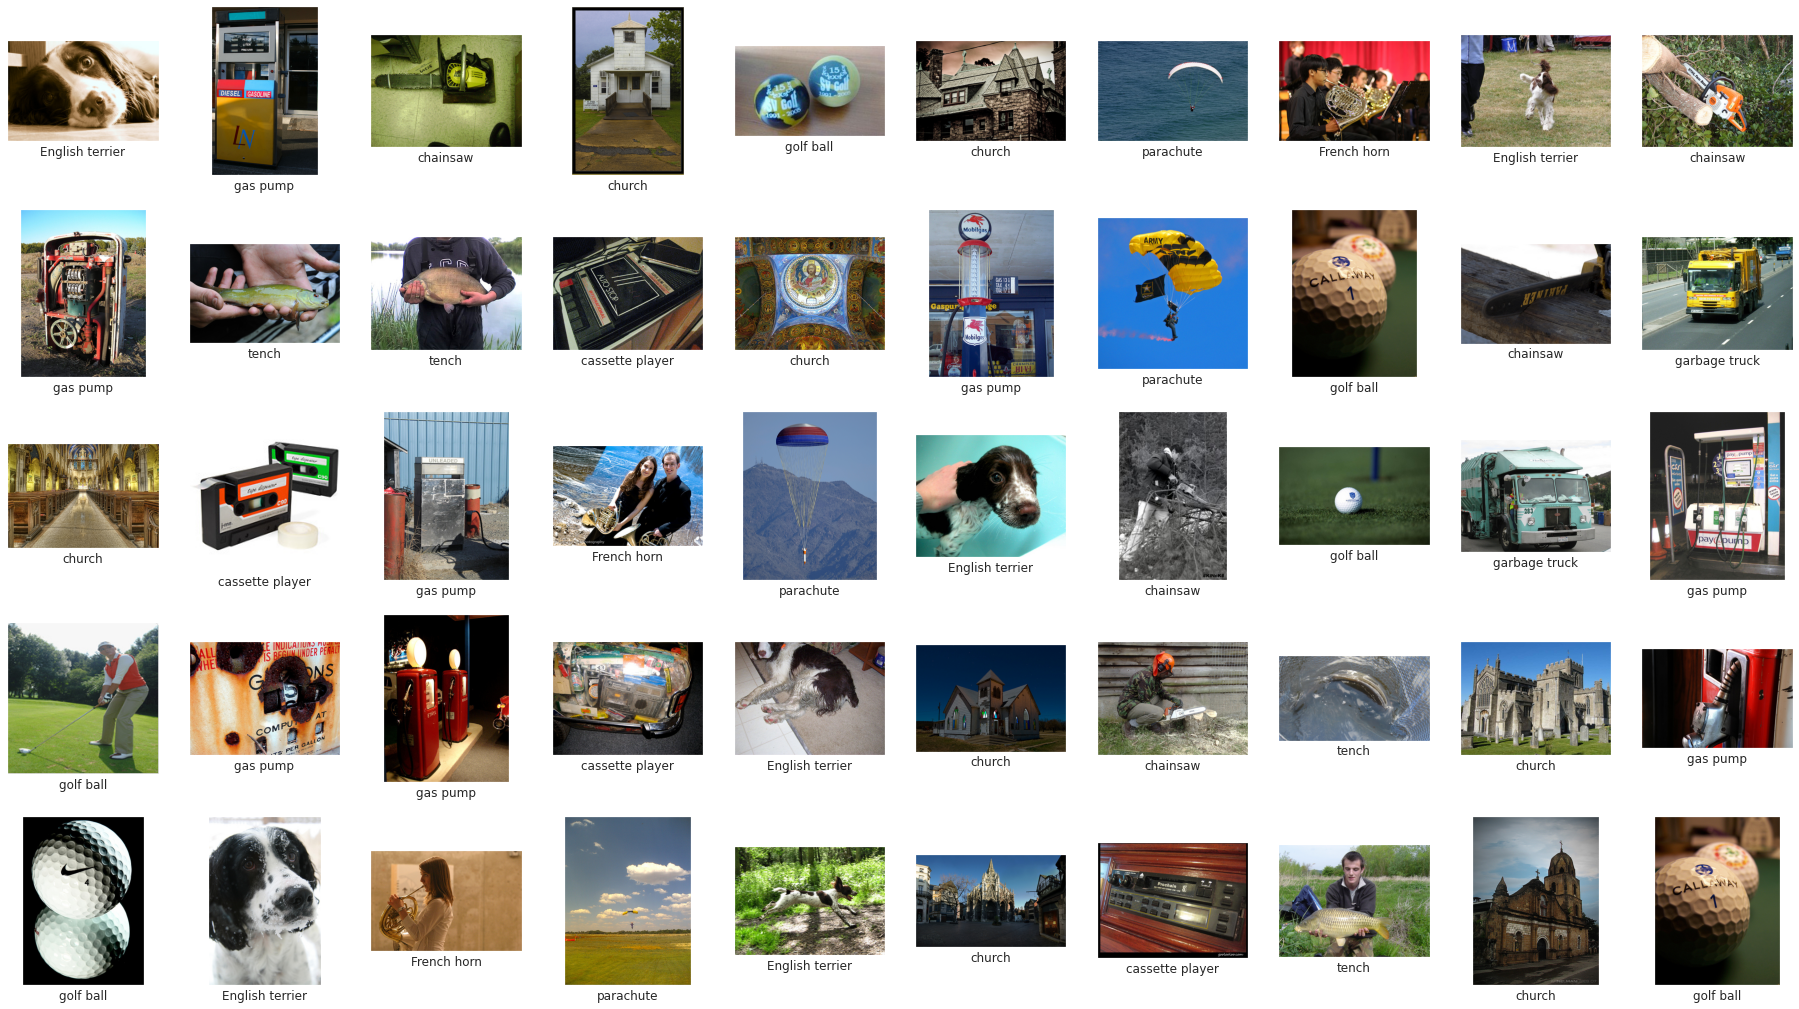

In [9]:
np.random.seed(23723)

image_samples = []

for i in range(50):
    sample_idx = np.random.choice(len(val_images))
    image_samples.append(val_images[sample_idx])

fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(32, 18))
for i in range(50):
    row = i // 10
    col = i - row * 10
    ax[row][col].imshow(imageio.imread(image_samples[i][0]))
    ax[row][col].set_xlabel(labels_class[image_samples[i][1]])
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])
plt.savefig(f"{plotdir_base}/imagenette_samples.png", dpi=600)

# Download pretrained model weights

We download the weights of a Wide Resnet 50 architecture pretrained on the entire ImageNet dataset as our starting point.

In [ ]:
net_pretrained = models.googlenet(pretrained=True)

# Transfer learning

Freeze weights in layers close to inputs (use them as fixed feature extractors)and retrain with only the 10 classes above for higher accuracy.

In [10]:
"""
This cell is generic setup
for data loading and the
training loop.
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
}

image_datasets = {'train': datasets.ImageFolder(train_dir,
                                          data_transforms['train']),
                  'val': datasets.ImageFolder(train_dir,
                                              data_transforms['val'])
                 }
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = [directory_dict[c] for c in image_datasets['train'].classes]

print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training loop function
def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

['tench', 'English terrier', 'cassette player', 'chainsaw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


# Training

Here is where we actually set our parameters to retrain the network.

First, we need to replace the output layer with an output layer that has as many nodes as the classes we want our network to classify (10, instead of the 1000 classes in ImageNet).

Then, we run the training loop above on this modified network. We will keep the weights of all layers except those closest to the output frozen, since those layers closer to the inputs are likely already useful feature extractors. We instead optimize only the parameters of the layers close to the output (including the new output layer initialized with random weights).

In [ ]:
# Replace nodes of the output layer with 10 new nodes.
# Initializes with random weights between hidden layer nodes
# and this new layer of output nodes.
hidden_nodes = net_pretrained.fc.in_features
output_nodes = num_classes
net_pretrained.fc = nn.Linear(hidden_nodes, num_classes)

# Freeze all parameters in lower layers.
for idx, child in enumerate(net_pretrained.children()):
    if idx <= 6:
        for param in child.parameters():
            param.requires_grad = False

# Send to GPU for fast training on Google Colab.
net_pretrained = net_pretrained.to(device)

# Use cross entropy as loss function.
loss = nn.CrossEntropyLoss()

# Use stochastic gradient descent with momentum.
optimizer = optim.SGD(net_pretrained.parameters(), lr=0.01, momentum=0.9)

# Retrain the network for 5 epochs.
net = train_model(net_pretrained, loss, optimizer,
                  num_epochs=5)

Epoch 1/5
----------
train Loss: 0.2087 Acc: 0.9437
val Loss: 0.0135 Acc: 0.9968

Epoch 2/5
----------
train Loss: 0.1099 Acc: 0.9666
val Loss: 0.0057 Acc: 0.9989

Epoch 3/5
----------
train Loss: 0.0925 Acc: 0.9710
val Loss: 0.0045 Acc: 0.9989

Epoch 4/5
----------
train Loss: 0.0773 Acc: 0.9755
val Loss: 0.0061 Acc: 0.9981

Epoch 5/5
----------
train Loss: 0.0739 Acc: 0.9768
val Loss: 0.0019 Acc: 0.9997

Training complete in 14m 14s
Best val Acc: 0.999683


# Save the model

The cell below serializes the trained model so the trained weights can be reloaded without having to train the model again.

In [ ]:
torch.save(net, '/content/gdrive/My Drive/imagenette_base_model_googlenet.pt')

# Load model

You can load the model trained above to avoid having to rerun training if you have to restart the notebook for some reason.

In [11]:
net = torch.load('/content/gdrive/My Drive/imagenette_base_model_googlenet.pt').to(device)

# Evaluate performance

Use network to get predictions for our sample images.

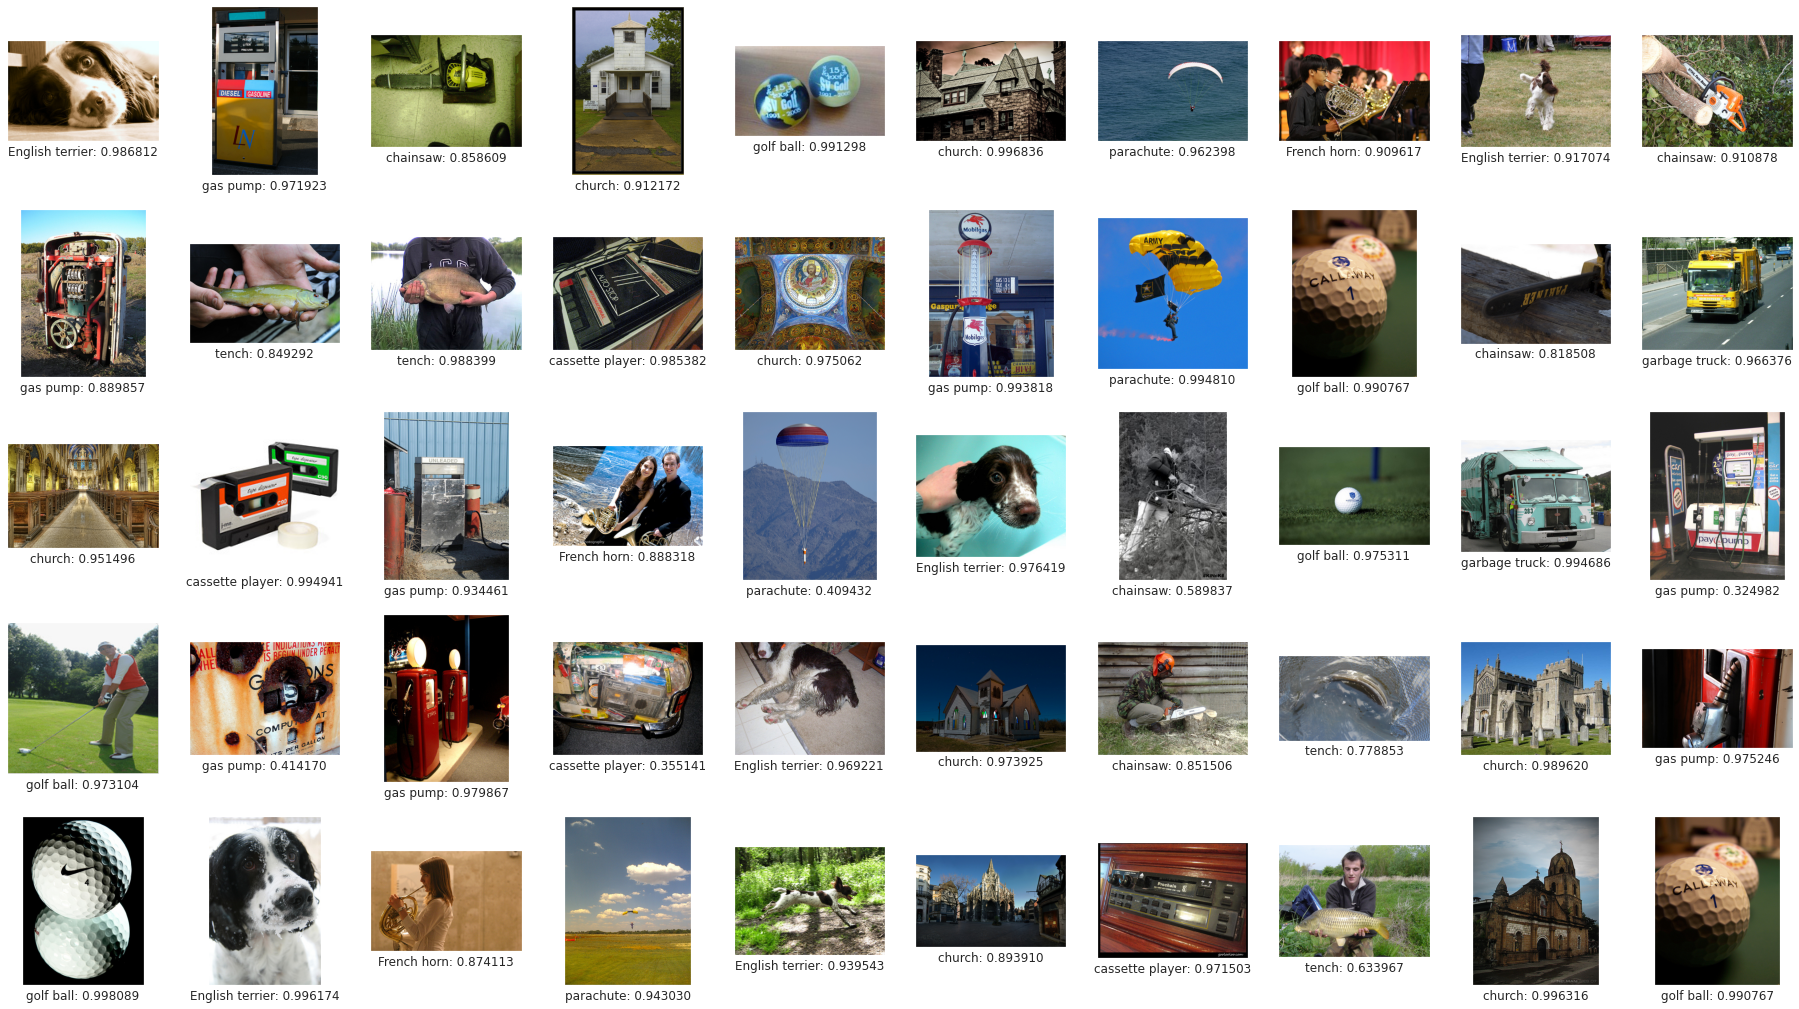

In [12]:
def predict_image(network, img):
    """
    Input: Image file path (str)
    Outputs: Predicted image class, probability assigned by network to top class
    """
    img_transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = img_transform(img).float().unsqueeze(0).to(device)
    outputs = network(input_tensor).squeeze()
    class_probas = nn.Softmax(dim=-1)(outputs).detach().cpu().numpy()
    idx = np.argmax(class_probas)
    img_class = class_names[idx]
    proba = class_probas[idx]
    return img_class, proba

# Predict on the same image samples as above.
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(32, 18))
for i in range(50):
  try:
    row = i // 10
    col = i - row * 10
    img = imageio.imread(image_samples[i][0])
    ax[row][col].imshow(img)
    predicted_class, predicted_proba = predict_image(net, img)
    ax[row][col].set_xlabel(f"{predicted_class}: {predicted_proba:.6f}")
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])
  except:
    print(f"failed on {i}")
plt.savefig(f"{plotdir_base}/imagenette_samples_base_predictions.png", dpi=600)

# Adversarial Attacks

Now we'll run some adversarial attacks on the network.

## Method 1: FGSM

Attack one uses the [Fast Gradient Sign Method](https://arxiv.org/abs/1412.6572). This is a very efficient method when we want to change the label of the network, but don't care what the new label becomes.

In [ ]:
def get_adversarial_image(network, img_tuple, epsilon=0.01):
    img_file, label = img_tuple
    img = imageio.imread(img_file)
    img_transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = img_transform(img).float().unsqueeze(0).to(device)
    input_tensor.requires_grad = True
    outputs = network(input_tensor)
    # Format label.
    class_name = labels_class[label]
    class_idx = class_names.index(class_name)
    label = torch.tensor(class_idx).unsqueeze(0).to(device)
    # Get loss gradient with regard to image pixels.
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(outputs, label)
    loss.backward()
    img_gradient = input_tensor.grad
    gradient_signs = torch.sign(img_gradient).cpu().numpy().squeeze()
    # Match shape of image (channels last in this case)
    gradient_signs = np.transpose(gradient_signs, axes=[1, 2, 0])
    pixel_changes = (gradient_signs * 255 * epsilon).astype(np.int16)
    changed_img = (img).astype(np.int16) + pixel_changes
    adv_img = np.clip(changed_img, 0, 255).astype(np.uint8)
    return adv_img

# Predict on FGSM (untargeted) adversarial versions of the images.
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(32, 18))
for i in range(50):
  try:
    row = i // 10
    col = i - row * 10
    adversarial_img = get_adversarial_image(net, image_samples[i], epsilon=0.025)
    ax[row][col].imshow(adversarial_img)
    predicted_class, predicted_proba = predict_image(net, adversarial_img)
    ax[row][col].set_xlabel(f"{predicted_class}: {predicted_proba:.6f}")
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])
  except:
    print(f"failed on {i}")
plt.savefig(f"{plotdir_base}/imagenette_samples_fgsm_predictions.png", dpi=600)

In [ ]:
true_labels = [labels_class[img_tuple[1]] for img_tuple in image_samples]
epsilons = [0.000, 0.025, 0.050, 0.075, 0.100,
            0.125, 0.150, 0.175, 0.200,
            0.225, 0.250, 0.275, 0.300] 
percent_correct = []
top_class_confidences = []
for eps in epsilons:
    total_correct = 0
    top_class_confidence = []
    for i in range(50):
      try:
        adversarial_img = get_adversarial_image(net, image_samples[i], epsilon=eps)
        predicted_class, predicted_proba = predict_image(net, adversarial_img)
        top_class_confidence.append(predicted_proba)
        if predicted_class == true_labels[i]:
            total_correct += 1
      except:
        print(f"failed on {i}")
    percent_correct.append(total_correct * 100.0 / 50)
    top_class_confidences.append(top_class_confidence)


In [ ]:
top_class_confidences_flat = [(e, p) for idx, e in enumerate(epsilons)
                              for p in top_class_confidences[idx]]
x_confidences = [c[0] for c in top_class_confidences_flat]
y_confidences = [c[1] for c in top_class_confidences_flat]
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(32, 18))
sns.lineplot(x=epsilons, y=percent_correct,
             markers=True, linewidth=3, ax=ax[0])
ax[0].set_ylabel('Percent correctly classified')
sns.boxplot(x=x_confidences, y=y_confidences, ax=ax[1])
ax[1].set_ylabel('Top class confidence')

plt.xlabel("epsilon")
plt.savefig(f"{plotdir_base}/imagenette_samples_fgsm_plots.png", dpi=600)

## Method 2: Directed attack

Now, we want to change all the labels to, say, English terrier. We can do this by solving a new minimization problem:

$\min_{\delta} \{L_{adv}(x + \delta) = L(x + \delta, y_{desired}) - L(x + \delta, y_{true})\} \text{ subject to } \|\delta\|_\infty \leq \epsilon$. Fixing $x$ and the network parameters $\theta$, we use forward passes and backpropagation for $N$ iterations and apply the following update rule to get the perturbation $\delta$ that we will use to generate the adversarial example:

$\delta_{t} = \delta_{t-1} - \alpha * sign(\nabla L_{adv}(x + \delta_{t-1}))$,

$\delta_{t} \leftarrow clip(\delta_{t}, -\epsilon, \epsilon)$

with $\delta_0 = \mathbf{0}$.

In the example below, we use the infinity norm $\|\delta\|_\infty$ to make the
constraint simple to implement by clipping, and also because what we care about is making changes to individual pixels as imperceptible as possible.

See the [Targeted attacks section of this page](https://adversarial-ml-tutorial.org/adversarial_examples/) and maybe look for a paper to cite.

In [ ]:
def get_adversarial_image_terrier(network, img_tuple, alpha=0.01, epsilon=0.02, num_iter=10):
    img_file, label = img_tuple
    img = imageio.imread(img_file)
    img_transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = img_transform(img).float().unsqueeze(0).to(device)
    input_tensor.requires_grad = True
    # Format label.
    class_name = labels_class[label]
    class_idx = class_names.index(class_name)
    label = torch.tensor(class_idx).unsqueeze(0).to(device)
    # Format desired label.
    desired_class_name = "English terrier"
    desired_class_idx = class_names.index(desired_class_name)
    desired_label = torch.tensor(desired_class_idx).unsqueeze(0).to(device)
    # Get loss gradient with regard to image pixels.
    loss_fn = nn.CrossEntropyLoss()
    # Delta
    delta = torch.zeros_like(input_tensor, requires_grad=True)
    for i in range(num_iter):
        outputs = network(input_tensor + delta)
        loss =  loss_fn(outputs, desired_label) - loss_fn(outputs, label)
        loss.backward()
        with torch.no_grad():
            delta -= alpha * delta.grad.sign()
            delta.data = delta.clamp(-epsilon, epsilon)
        delta.grad.zero_()
    delta_final = delta.detach().cpu().numpy().squeeze()
    # Match shape of image (channels last in this case)
    delta_final = np.transpose(delta_final, axes=[1, 2, 0])
    pixel_changes = (delta_final * 255).astype(np.int16)
    changed_img = (img).astype(np.int16) + pixel_changes
    adv_img = np.clip(changed_img, 0, 255).astype(np.uint8)
    return adv_img

"""
Note:

The function above is not the most
efficient implementation. Running it in batch
mode should be faster, but I threw this together
quickly for a proof of concept.
"""
# Predict on targeted adversarial versions of the images.
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(32, 18))
for i in range(50):
  try:
    row = i // 10
    col = i - row * 10
    adversarial_img = get_adversarial_image_terrier(net, image_samples[i],
                                                    alpha=0.01, epsilon=0.02,
                                                    num_iter=10)
    ax[row][col].imshow(adversarial_img)
    predicted_class, predicted_proba = predict_image(net, adversarial_img)
    ax[row][col].set_xlabel(f"{predicted_class}: {predicted_proba:.6f}")
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])
  except:
    print(f"failed on {i}")
plt.savefig(f"{plotdir_base}/imagenette_samples_directed_attack_predictions.png", dpi=600)

In [ ]:
epsilons_directed = [0.000, 0.001, 0.002, 0.003, 0.004, 0.005,
                     0.006, 0.007, 0.008, 0.009, 0.010,
                     0.011, 0.012, 0.013, 0.014, 0.015]
percent_terrier = []
terrier_class_confidences = []
for eps in epsilons_directed:
    total_terrier = 0
    terrier_class_confidence = []
    for i in range(50):
      try:
        adversarial_img = get_adversarial_image_terrier(net, image_samples[i],
                                                        alpha=0.01, epsilon=eps,
                                                        num_iter=10)
        predicted_class, predicted_proba = predict_image(net, adversarial_img)
        if predicted_class == "English terrier":
            total_terrier += 1
            terrier_class_confidence.append(predicted_proba)
      except:
        print(f"failed on {i}")
    percent_terrier.append(total_terrier * 100.0 / 50)
    terrier_class_confidences.append(terrier_class_confidence)

In [ ]:
terrier_class_confidences_flat = [(e, p) for idx, e in enumerate(epsilons_directed)
                                  for p in terrier_class_confidences[idx]]
x_confidences_dir = [c[0] for c in terrier_class_confidences_flat]
y_confidences_dir = [c[1] for c in terrier_class_confidences_flat]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(32, 18))
sns.lineplot(x=epsilons_directed, y=percent_terrier,
             markers=True, linewidth=3, ax=ax)
ax.set_ylabel('Percent classified as English terrier')
plt.xlabel("epsilon")
plt.savefig(f"{plotdir_base}/imagenette_samples_directed_attack_plots.png", dpi=600)

# Example Perturbation

Below we show an example of an original image that is correctly classified with high accuracy by the network ($> 99\%$ confidence), the added noise (scaled so it is easy to see), and the perturbed image generated by the directed attack, which is classified as an English terrier with $\sim 100\%$ confidence. 

In [ ]:
sample_idx = 20
img = imageio.imread(image_samples[sample_idx][0])
predicted_class, predicted_proba = predict_image(net, img)
adversarial_img = get_adversarial_image_terrier(net, image_samples[sample_idx],
                                                alpha=0.01, epsilon=0.02,
                                                num_iter=10)
predicted_class_adv, predicted_proba_adv = predict_image(net, adversarial_img)
noise = adversarial_img - img
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(32, 18))
ax[0].imshow(img)
ax[0].set_xlabel(f"{predicted_class}: {predicted_proba:.6f}")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(noise)
ax[1].set_xlabel(f"epsilon = 0.02")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].imshow(adversarial_img)
ax[2].set_xlabel(f"{predicted_class_adv}: {predicted_proba_adv:.6f}")
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.savefig(f"{plotdir_base}/adversarial_example.png", dpi=600)

# First Adversarial Defense: Perturbed Prediction Averaging

One method of defense against FGSM and directed adversarial attacks based on the gradients of the network that does not require retraining the network, and which can be used when inference time is not the primary concern, is to predict the class for each image based on an ensemble prediction for the original image and $N - 1$ additional perturbed versions of the image, with the perturbations drawn uniformly from the $\epsilon^*$ $\ell_\infty$-ball around the image, where $\epsilon^*$ is at a level greater than would be expected from an adversarial attack. For example, $\epsilon^*$ can be set large enough that a uniform random $\|\delta\|_\infty \leq \epsilon^*$ perturbation would be easily noticed by a human. If that's the case, we can probably assume that adversarial attacks will use an $\epsilon$ bound significantly less than $\epsilon^*$. Using a modified softmax function, we can express the probability for class $k$ of $\{1,2,\cdots,K\}$ classes predicted using this defense as

$P(y_{k}|x) = \frac{\sum_{i=1}^{N}{e^z_k(x + \delta_i)}}{\sum_{j=1}^{K}{\sum_{i=1}^{N}{e^z_j(x + \delta_i)}}}$,

where $z_j(\cdot)$ is the output of the $j^{\text{th}}$ hidden node for a given network input and with $\delta_1 = \mathbf{0}$, $\|\delta_i\|_\infty \leq \epsilon^* \text{ } \forall i$.

## Example of $\|\delta\|_\infty \leq \epsilon^*$ perturbation

Setting $\epsilon^* = 0.3$, the perturbation is easily noticeable. We can reasonably expect adversarial attacks on monitored systems to have an $\epsilon < \epsilon^*$.

Of course, setting $\epsilon^*$ too high can lead to inaccurate results, since the network was not trained on such noisy data. There has to be a balance with this defense.

In [ ]:
img = imageio.imread(image_samples[sample_idx][0])
eps_star = 0.3
pixel_changes = (255 * (2 * eps_star
                        * np.random.uniform(0, 1.0, size=img.shape) - eps_star)).astype(np.int16)
changed_img = (img).astype(np.int16) + pixel_changes
adversarial_img = np.clip(changed_img, 0, 255).astype(np.uint8)
noise = adversarial_img - img
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(32, 18))
ax[0].imshow(img)
ax[0].set_xlabel(f"Original image")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(noise)
ax[1].set_xlabel(f"epsilon = {eps_star}")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].imshow(adversarial_img)
ax[2].set_xlabel(f"Perturbed image")
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.savefig(f"{plotdir_robust_avg}/eps_star_example.png", dpi=600)

## Defense Example

Consider a directed attack on the same image as above, but now we use the robust prediction method to classify the image.

In [ ]:
def robust_predict_image(network, img, epsilon=0.3, n=20):
    """
    Input: Image file path (str)
    Outputs: Predicted image class, probability assigned by network to top class
    """
    with torch.no_grad():
        img_transform = transforms.Compose([transforms.ToTensor()])
        img_tensor = img_transform(img).float().unsqueeze(0)
        # Predict with original image and additional images
        # with random perturbations in the epsilon infinity-norm ball
        # around the original image.
        # Avergae the predictions.
        input_tensor = torch.cat([img_tensor] * n).to(device)
        delta = (2 * epsilon * torch.rand(input_tensor.shape) - epsilon).to(device)
        delta[0, :, :, :] = torch.zeros_like(img_tensor[0, :, :, :])
        input_tensor += delta
        all_outputs = network(input_tensor).squeeze()
        outputs = torch.sum(all_outputs, dim=0)
    class_probas = nn.Softmax(dim=-1)(outputs).detach().cpu().numpy()
    idx = np.argmax(class_probas)
    img_class = class_names[idx]
    proba = class_probas[idx]
    return img_class, proba

# Predict on targeted adversarial versions of the images.
sample_idx = 20
img = imageio.imread(image_samples[sample_idx][0])
predicted_class, predicted_proba = robust_predict_image(net, img)
adversarial_img = get_adversarial_image_terrier(net, image_samples[sample_idx],
                                                alpha=0.01, epsilon=0.02,
                                                num_iter=10)
predicted_class_adv, predicted_proba_adv = robust_predict_image(net, adversarial_img)
noise = adversarial_img - img
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(32, 18))
ax[0].imshow(img)
ax[0].set_xlabel(f"{predicted_class}: {predicted_proba:.6f}")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(noise)
ax[1].set_xlabel(f"epsilon = 0.02")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].imshow(adversarial_img)
ax[2].set_xlabel(f"{predicted_class_adv}: {predicted_proba_adv:.6f}")
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.savefig(f"{plotdir_robust_avg}/adversarial_example.png", dpi=600)

# Test Attacks Against Robust Prediction

We test FGSM and directed gradient attacks against the network, but now we use the robust prediction method to classify images.

## FGSM

In [ ]:
# Predict on FGSM (untargeted) adversarial versions of the images.
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(32, 18))
for i in range(50):
  try:
    row = i // 10
    col = i - row * 10
    adversarial_img = get_adversarial_image(net, image_samples[i], epsilon=0.025)
    ax[row][col].imshow(adversarial_img)
    predicted_class, predicted_proba = robust_predict_image(net, adversarial_img)
    ax[row][col].set_xlabel(f"{predicted_class}: {predicted_proba:.6f}")
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])
  except:
    print(f"failed on {i}")
plt.savefig(f"{plotdir_robust_avg}/imagenette_samples_fgsm_predictions.png", dpi=600)

In [ ]:
true_labels = [labels_class[img_tuple[1]] for img_tuple in image_samples]
epsilons = [0.000, 0.025, 0.050, 0.075, 0.100,
            0.125, 0.150, 0.175, 0.200,
            0.225, 0.250, 0.275, 0.300] 
percent_correct = []
top_class_confidences = []
for eps in epsilons:
    total_correct = 0
    top_class_confidence = []
    for i in range(50):
        adversarial_img = get_adversarial_image(net, image_samples[i], epsilon=eps)
        predicted_class, predicted_proba = robust_predict_image(net, adversarial_img)
        top_class_confidence.append(predicted_proba)
        if predicted_class == true_labels[i]:
            total_correct += 1
    percent_correct.append(total_correct * 100.0 / 50)
    top_class_confidences.append(top_class_confidence)

In [ ]:
top_class_confidences_flat = [(e, p) for idx, e in enumerate(epsilons)
                              for p in top_class_confidences[idx]]
x_confidences = [c[0] for c in top_class_confidences_flat]
y_confidences = [c[1] for c in top_class_confidences_flat]
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(32, 18))
sns.lineplot(x=epsilons, y=percent_correct,
             markers=True, linewidth=3, ax=ax[0])
ax[0].set_ylabel('Percent correctly classified')
sns.boxplot(x=x_confidences, y=y_confidences, ax=ax[1])
ax[1].set_ylabel('Top class confidence')

plt.xlabel("epsilon")
plt.savefig(f"{plotdir_robust_avg}/imagenette_samples_fgsm_plots.png", dpi=600)

## Directed Attack

In [ ]:
# Predict on targeted adversarial versions of the images.
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(32, 18))
for i in range(50):
  try:
    row = i // 10
    col = i - row * 10
    adversarial_img = get_adversarial_image_terrier(net, image_samples[i],
                                                    alpha=0.01, epsilon=0.02,
                                                    num_iter=10)
    ax[row][col].imshow(adversarial_img)
    predicted_class, predicted_proba = robust_predict_image(net, adversarial_img)
    ax[row][col].set_xlabel(f"{predicted_class}: {predicted_proba:.6f}")
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])
  except:
    print(f"failed on {i}")
plt.savefig(f"{plotdir_robust_avg}/imagenette_samples_directed_attack_predictions.png", dpi=600)

In [ ]:
epsilons_directed = [0.000, 0.001, 0.002, 0.003, 0.004, 0.005,
                     0.006, 0.007, 0.008, 0.009, 0.010,
                     0.011, 0.012, 0.013, 0.014, 0.015]
percent_terrier = []
terrier_class_confidences = []
for eps in epsilons_directed:
    total_terrier = 0
    terrier_class_confidence = []
    for i in range(50):
      try:
        adversarial_img = get_adversarial_image_terrier(net, image_samples[i],
                                                        alpha=0.01, epsilon=eps,
                                                        num_iter=10)
        predicted_class, predicted_proba = robust_predict_image(net, adversarial_img)
        if predicted_class == "English terrier":
            total_terrier += 1
            terrier_class_confidence.append(predicted_proba)
      except:
        print(f"failed on {i}")
    percent_terrier.append(total_terrier * 100.0 / 50)
    terrier_class_confidences.append(terrier_class_confidence)

In [ ]:
terrier_class_confidences_flat = [(e, p) for idx, e in enumerate(epsilons_directed)
                                  for p in terrier_class_confidences[idx]]
x_confidences_dir = [c[0] for c in terrier_class_confidences_flat]
y_confidences_dir = [c[1] for c in terrier_class_confidences_flat]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(32, 18))
sns.lineplot(x=epsilons_directed, y=percent_terrier,
             markers=True, linewidth=3, ax=ax)
ax.set_ylabel('Percent classified as English terrier')
plt.xlabel("epsilon")
plt.savefig(f"{plotdir_robust_avg}/imagenette_samples_directed_attack_plots.png", dpi=600)

# Second Adversarial Defense: Training with Adversarial Examples

We now generate adversarial examples during training to make the model robust. The adversarial examples use the directed method, but the attack is directed towards a random class (instead of just the English terrier class like in the examples above).

We use FGSM for the adversarial training examples rather than random directed attacks to keep the training time reasonable.

### Training notes

Trained network using the directed attack method with a random $\alpha \sim \mathcal{U}(0, 0.02)$ (shared for all attacks on images in the same minibatch) and $\epsilon = 0.02$ with $N=3$ iterations to optimize for $\delta$. The target class for the attack on each image was chosen randomly as $y_{desired} \sim \mathcal{U}\{0,1,\cdots,9\}$ from among the 10 class labels.

The starting weights for the network were the weights of the network used for the examples above. All weights were trainable for the robust network. The network was trained for 10 epochs with a learning rate $\eta = 0.01$.

Momentum was not used, since a run with momentum showed the network became unable to overcome the adversarial attacks during training, so that classification performance remained low.

Each training run takes several hours using a Tesla P100 GPU, so we couldn't do extensive hyperparameter optimization.

In [ ]:
!nvidia-smi

In [ ]:
def get_random_adversarial_delta(network, inputs, labels,
                                 alpha_max=0.02, epsilon=0.02, num_iter=10):
    input_tensor = inputs.to(device)
    input_tensor.requires_grad = True
    label = labels.to(device)
    # To keep things simple, each mini-batch will have a 
    # single epsilon and alpha.
    alpha = np.random.uniform(low=0.0, high=alpha_max)
    # Do a directed attack toward a random label for each image.
    desired_label = torch.randint(low=0, high=num_classes,
                                  size=labels.shape).to(device)
    # Get loss gradient with regard to image pixels.
    loss_fn = nn.CrossEntropyLoss()
    # Delta
    delta = torch.zeros_like(input_tensor, requires_grad=True)
    for i in range(num_iter):
        outputs = network(input_tensor + delta)
        loss =  loss_fn(outputs, desired_label) - loss_fn(outputs, label)
        loss.backward()
        with torch.no_grad():
            delta -= alpha * delta.grad.sign()
            delta.data = delta.clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

# Training loop function
def train_robust_model(model, criterion, optimizer,
                       num_epochs=25, alpha_max=0.02, epsilon=0.02,
                       num_adv_iter=5):
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # Use self as adversary.
                inputs = inputs.to(device)
                deltas = get_random_adversarial_delta(model, inputs,
                            labels, alpha_max=alpha_max, epsilon=epsilon,
                            num_iter=num_adv_iter)
                inputs = inputs + deltas
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.8f} Acc: {:.8f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model

In [ ]:
net_pretrained = net

# Freeze all parameters in lower layers.
for param in net_pretrained.parameters():
    param.requires_grad = True

# Use cross entropy as loss function.
loss = nn.CrossEntropyLoss()

# Use stochastic gradient descent with momentum.
optimizer = optim.SGD(net_pretrained.parameters(), lr=0.01)

# Retrain the network for 5 epochs using adversarial examples.
net_robust = train_robust_model(net_pretrained, loss, optimizer,
                                num_epochs=10, num_adv_iter=3)

## Save the robust model

In [ ]:
torch.save(net_robust, '/content/gdrive/My Drive/imagenette_robust_model.pt')

## Load the robust model

In [ ]:
net_robust = torch.load('/content/gdrive/My Drive/imagenette_robust_model.pt').to(device)

# Test Attacks Against Robust Network

We test FGSM and directed gradient attacks against the network, but now we use the robust network to classify images.

## Sample image

In [ ]:
sample_idx = 20
img = imageio.imread(image_samples[sample_idx][0])
predicted_class, predicted_proba = predict_image(net_robust, img)
adversarial_img = get_adversarial_image_terrier(net_robust, image_samples[sample_idx],
                                                alpha=0.01, epsilon=0.02,
                                                num_iter=10)
predicted_class_adv, predicted_proba_adv = predict_image(net_robust, adversarial_img)
noise = adversarial_img - img
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(32, 18))
ax[0].imshow(img)
ax[0].set_xlabel(f"{predicted_class}: {predicted_proba:.6f}")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(noise)
ax[1].set_xlabel(f"epsilon = 0.02")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].imshow(adversarial_img)
ax[2].set_xlabel(f"{predicted_class_adv}: {predicted_proba_adv:.6f}")
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.savefig(f"{plotdir_robust_net}/adversarial_example.png", dpi=600)

## FGSM

In [ ]:
# Predict on FGSM (untargeted) adversarial versions of the images.
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(32, 18))
for i in range(50):
  try:
    row = i // 10
    col = i - row * 10
    adversarial_img = get_adversarial_image(net_robust, image_samples[i], epsilon=0.025)
    ax[row][col].imshow(adversarial_img)
    predicted_class, predicted_proba = predict_image(net_robust, adversarial_img)
    ax[row][col].set_xlabel(f"{predicted_class}: {predicted_proba:.6f}")
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])
  except:
    print(f"failed on {i}")
plt.savefig(f"{plotdir_robust_net}/imagenette_samples_fgsm_predictions.png", dpi=600)

In [ ]:
true_labels = [labels_class[img_tuple[1]] for img_tuple in image_samples]
epsilons = [0.000, 0.025, 0.050, 0.075, 0.100,
            0.125, 0.150, 0.175, 0.200,
            0.225, 0.250, 0.275, 0.300] 
percent_correct = []
top_class_confidences = []
for eps in epsilons:
    total_correct = 0
    top_class_confidence = []
    for i in range(50):
      try:
        adversarial_img = get_adversarial_image(net_robust, image_samples[i], epsilon=eps)
        predicted_class, predicted_proba = predict_image(net_robust, adversarial_img)
        top_class_confidence.append(predicted_proba)
        if predicted_class == true_labels[i]:
            total_correct += 1
      except:
        print(f"failed on {i}")
    percent_correct.append(total_correct * 100.0 / 50)
    top_class_confidences.append(top_class_confidence)

In [ ]:
top_class_confidences_flat = [(e, p) for idx, e in enumerate(epsilons)
                              for p in top_class_confidences[idx]]
x_confidences = [c[0] for c in top_class_confidences_flat]
y_confidences = [c[1] for c in top_class_confidences_flat]
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(32, 18))
sns.lineplot(x=epsilons, y=percent_correct,
             markers=True, linewidth=3, ax=ax[0])
ax[0].set_ylabel('Percent correctly classified')
sns.boxplot(x=x_confidences, y=y_confidences, ax=ax[1])
ax[1].set_ylabel('Top class confidence')

plt.xlabel("epsilon")
plt.savefig(f"{plotdir_robust_net}/imagenette_samples_fgsm_plots.png", dpi=600)

## Directed Attack

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(32, 18))
for i in range(50):
  try:
    row = i // 10
    col = i - row * 10
    adversarial_img = get_adversarial_image_terrier(net_robust, image_samples[i],
                                                    alpha=0.01, epsilon=0.02,
                                                    num_iter=10)
    ax[row][col].imshow(adversarial_img)
    predicted_class, predicted_proba = predict_image(net_robust, adversarial_img)
    ax[row][col].set_xlabel(f"{predicted_class}: {predicted_proba:.6f}")
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])
  except:
    print(f"failed on {i}")
plt.savefig(f"{plotdir_robust_net}/imagenette_samples_directed_attack_predictions.png", dpi=600)

In [ ]:
epsilons_directed = [0.000, 0.001, 0.002, 0.003, 0.004, 0.005,
                     0.006, 0.007, 0.008, 0.009, 0.010,
                     0.011, 0.012, 0.013, 0.014, 0.015] 
percent_terrier = []
terrier_class_confidences = []
for eps in epsilons_directed:
    total_terrier = 0
    terrier_class_confidence = []
    for i in range(50):
        adversarial_img = get_adversarial_image_terrier(net_robust, image_samples[i],
                                                        alpha=0.01, epsilon=eps,
                                                        num_iter=10)
        predicted_class, predicted_proba = predict_image(net_robust, adversarial_img)
        if predicted_class == "English terrier":
            total_terrier += 1
            terrier_class_confidence.append(predicted_proba)
    percent_terrier.append(total_terrier * 100.0 / 50)
    terrier_class_confidences.append(terrier_class_confidence)

In [ ]:
terrier_class_confidences_flat = [(e, p) for idx, e in enumerate(epsilons_directed)
                                  for p in terrier_class_confidences[idx]]
x_confidences_dir = [c[0] for c in terrier_class_confidences_flat]
y_confidences_dir = [c[1] for c in terrier_class_confidences_flat]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(32, 18))
sns.lineplot(x=epsilons_directed, y=percent_terrier,
             markers=True, linewidth=3, ax=ax)
ax.set_ylabel('Percent classified as English terrier')
plt.xlabel("epsilon")
plt.savefig(f"{plotdir_robust_net}/imagenette_samples_directed_attack_plots.png", dpi=600)